<a href="https://colab.research.google.com/github/PsorTheDoctor/Sekcja-SI/blob/master/quantum_neural_networks/quantum_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Kwantowa konwolucyjna sieć neuronowa

In [2]:
!pip install -q tensorflow-quantum

     |████████████████████████████████| 5.9MB 3.4MB/s 
     |████████████████████████████████| 1.6MB 41.5MB/s 
     |████████████████████████████████| 5.6MB 42.4MB/s 


In [3]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# narzędzia do wizualizacji
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

##Budowa QCNN

In [4]:
qubit = cirq.GridQubit(0, 0)

# Definicja paru obwodów
circuit1 = cirq.Circuit(cirq.X(qubit))
circuit2 = cirq.Circuit(cirq.H(qubit))

# Konwersja do tensora
input_circuit_tensor = tfq.convert_to_tensor([circuit1, circuit2])

# Definicja obwodu, który chcemy dołączyć
y_circuit = cirq.Circuit(cirq.Y(qubit))

# Tworzenie instancji naszej warstwy
y_appender = tfq.layers.AddCircuit()

output_circuit_tensor = y_appender(input_circuit_tensor, append=y_circuit)

In [5]:
print(tfq.from_tensor(input_circuit_tensor))

[cirq.Circuit([
    cirq.Moment(
        cirq.X(cirq.GridQubit(0, 0)),
    ),
])
 cirq.Circuit([
    cirq.Moment(
        cirq.H(cirq.GridQubit(0, 0)),
    ),
])]


In [6]:
def generate_data(qubits):
  # Generowanie danych treningowych i testowych
  n_rounds = 20
  excitations = []
  labels = []
  for n in range(n_rounds):
    for bit in qubits:
      rng = np.random.uniform(-np.pi, np.pi)
      excitations.append(cirq.Circuit(cirq.rx(rng)(bit)))
      labels.append(1 if (-np.pi / 2) <= rng <= (np.pi / 2) else -1)
  
  split_ind = int(len(excitations) * 0.7)
  train_excitations = excitations[:split_ind]
  test_excitations = excitations[split_ind:]

  train_labels = labels[:split_ind]
  test_labels = labels[split_ind:]

  return tfq.convert_to_tensor(train_excitations), np.array(train_labels), \
    tfq.convert_to_tensor(test_excitations), np.array(test_labels)

In [7]:
sample_points, sample_labels, _, _ = generate_data(cirq.GridQubit.rect(1, 4))

print('Input:', tfq.from_tensor(sample_points)[0], 'Output:', sample_labels[0])
print('Input:', tfq.from_tensor(sample_points)[1], 'Output:', sample_labels[1])

Input: (0, 0): ───Rx(0.956π)─── Output: -1
Input: (0, 1): ───Rx(-0.245π)─── Output: 1


###Definicja warstw
####Stan klastra

In [8]:
def cluster_state_circuit(bits):

  circuit = cirq.Circuit()
  circuit.append(cirq.H.on_each(bits))
  for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
    circuit.append(cirq.CZ(this_bit, next_bit))
  return circuit

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


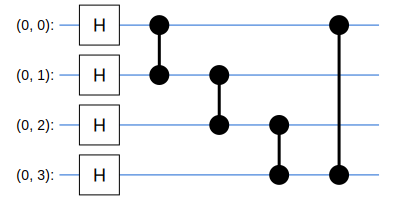

In [9]:
SVGCircuit(cluster_state_circuit(cirq.GridQubit.rect(1, 4)))

####Warstwy QCNN

In [10]:
def one_qubit_unitary(bit, symbols):

  return cirq.Circuit(
      cirq.X(bit) ** symbols[0],
      cirq.Y(bit) ** symbols[1],
      cirq.Z(bit) ** symbols[2])
  
def two_qubit_unitary(bits, symbols):

  circuit = cirq.Circuit()
  circuit += one_qubit_unitary(bits[0], symbols[0:3])
  circuit += one_qubit_unitary(bits[1], symbols[3:6])
  circuit += [cirq.ZZ(*bits) ** symbols[6]]
  circuit += [cirq.YY(*bits) ** symbols[7]]
  circuit += [cirq.XX(*bits) ** symbols[8]]
  circuit += one_qubit_unitary(bits[0], symbols[9:12])
  circuit += one_qubit_unitary(bits[1], symbols[12:])
  return circuit

def two_qubit_pool(source_qubit, sink_qubit, symbols):

  pool_circuit = cirq.Circuit()
  sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
  source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
  pool_circuit.append(sink_basis_selector)
  pool_circuit.append(source_basis_selector)
  pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
  pool_circuit.append(sink_basis_selector ** -1)
  return pool_circuit

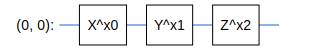

In [11]:
SVGCircuit(one_qubit_unitary(cirq.GridQubit(0, 0), sympy.symbols('x0:3')))

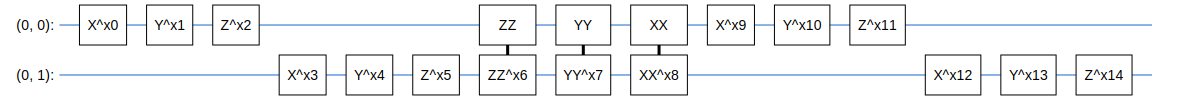

In [12]:
SVGCircuit(two_qubit_unitary(cirq.GridQubit.rect(1, 2), sympy.symbols('x0:15')))

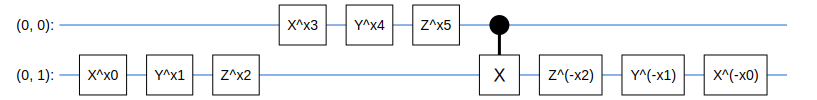

In [13]:
SVGCircuit(two_qubit_pool(*cirq.GridQubit.rect(1, 2), sympy.symbols('x0:6')))

####Kwantowa konwolucja

In [14]:
def quantum_conv_circuit(bits, symbols):
  
  circuit = cirq.Circuit()
  for first, second in zip(bits[0::2], bits[1::2]):
    circuit += two_qubit_unitary([first, second], symbols)
  for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
    circuit += two_qubit_unitary([first, second], symbols)
  return circuit

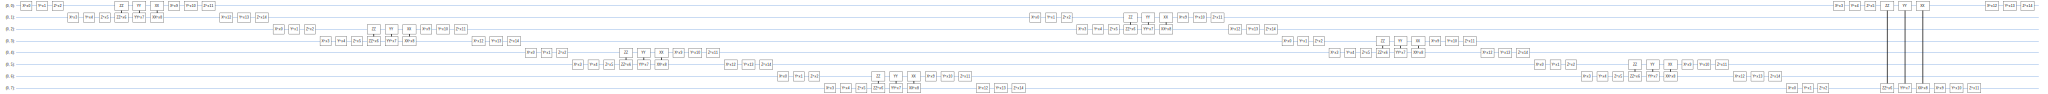

In [15]:
SVGCircuit(quantum_conv_circuit(cirq.GridQubit.rect(1, 8), sympy.symbols('x0:15')))

####Kwantowy pooling

In [16]:
def quantum_pool_circuit(source_bits, sink_bits, symbols):

  circuit = cirq.Circuit()
  for source, sink in zip(source_bits, sink_bits):
    circuit += two_qubit_pool(source, sink, symbols)
  return circuit

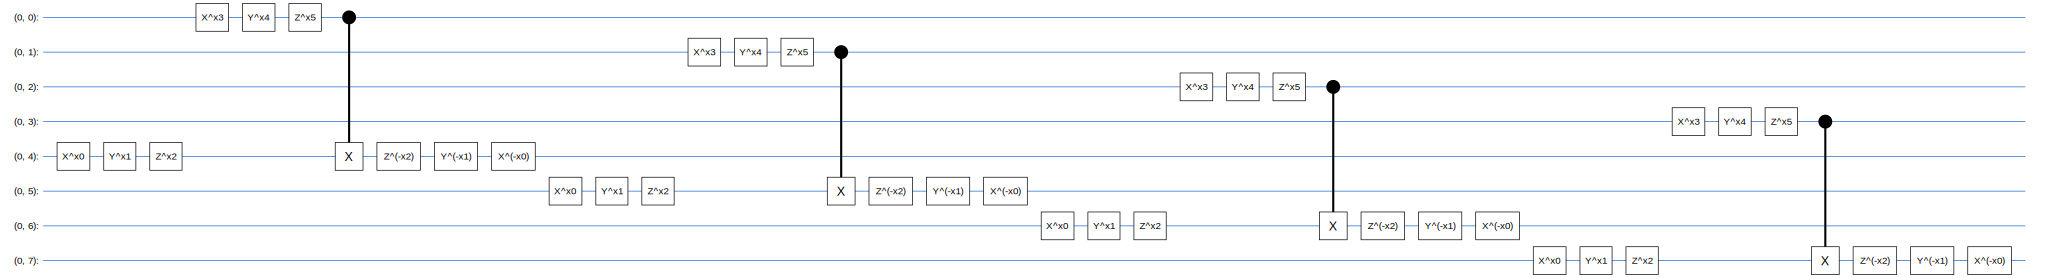

In [17]:
test_bits = cirq.GridQubit.rect(1, 8)

SVGCircuit(quantum_pool_circuit(test_bits[:4], test_bits[4:], sympy.symbols('x0:6')))

###Definicja modelu

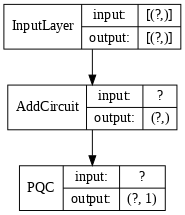

In [18]:
def create_model_circuit(qubits):
  
  model_circuit = cirq.Circuit()
  symbols = sympy.symbols('qconv0:63')
  # Cirq używa sympy.Symbols do mapowania zmiennych podlegających uczeniu.
  # Tensorflow Quantum sprawdza przychodzące obwody i zamienia je na zmienne Tensorflow.
  model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
  model_circuit += quantum_pool_circuit(qubits[:4], qubits[4:], symbols[15:21])

  model_circuit += quantum_conv_circuit(qubits[4:], symbols[21:36])
  model_circuit += quantum_pool_circuit(qubits[4:6], qubits[6:], symbols[36:42])

  model_circuit += quantum_conv_circuit(qubits[6:], symbols[42:57])
  model_circuit += quantum_pool_circuit([qubits[6]], [qubits[7]], symbols[57:63])
  return model_circuit

# Tworzenie naszych kubitów i operatorów odczytu w Cirq
cluster_state_bits = cirq.GridQubit.rect(1, 8)
readout_operators = cirq.Z(cluster_state_bits[-1])

excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
cluster_state = tfq.layers.AddCircuit()(
    excitation_input, prepend=cluster_state_circuit(cluster_state_bits))

quantum_model = tfq.layers.PQC(create_model_circuit(cluster_state_bits),
                               readout_operators)(cluster_state)

qcnn_model = tf.keras.Model(inputs=[excitation_input], outputs=[quantum_model])

tf.keras.utils.plot_model(qcnn_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

###Trening modelu

In [19]:
train_excitations, train_labels, test_excitations, test_labels = generate_data(
    cluster_state_bits)

@tf.function
def custom_accuracy(y_true, y_pred):
  y_true = tf.squeeze(y_true)
  y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
  return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))

qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.losses.mse,
                   metrics=[custom_accuracy])

history = qcnn_model.fit(x=train_excitations,
                         y=train_labels,
                         batch_size=16,
                         epochs=25,
                         verbose=1,
                         validation_data=(test_excitations, test_labels))

Epoch 1/25
7/7 [==============================] - 1s 130ms/step - loss: 0.8865 - custom_accuracy: 0.7143 - val_loss: 0.8459 - val_custom_accuracy: 0.7917
Epoch 2/25
7/7 [==============================] - 1s 124ms/step - loss: 0.7137 - custom_accuracy: 0.8304 - val_loss: 0.7158 - val_custom_accuracy: 0.8750
Epoch 3/25
7/7 [==============================] - 1s 125ms/step - loss: 0.5744 - custom_accuracy: 0.9107 - val_loss: 0.6077 - val_custom_accuracy: 0.8125
Epoch 4/25
7/7 [==============================] - 1s 126ms/step - loss: 0.4180 - custom_accuracy: 0.9554 - val_loss: 0.4013 - val_custom_accuracy: 0.9167
Epoch 5/25
7/7 [==============================] - 1s 128ms/step - loss: 0.3387 - custom_accuracy: 0.9821 - val_loss: 0.3587 - val_custom_accuracy: 0.8958
Epoch 6/25
7/7 [==============================] - 1s 129ms/step - loss: 0.2960 - custom_accuracy: 0.9821 - val_loss: 0.3165 - val_custom_accuracy: 0.9583
Epoch 7/25
7/7 [==============================] - 1s 128ms/step - loss: 0.27

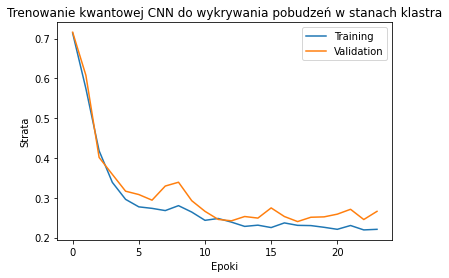

In [20]:
plt.plot(history.history['loss'][1:], label='Training')
plt.plot(history.history['val_loss'][1:], label='Validation')
plt.title('Trenowanie kwantowej CNN do wykrywania pobudzeń w stanach klastra')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

##Modele hybrydowe
###Model hybrydowy z pojedynczym filtrem kwantowym